In [3]:
%matplotlib inline
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [4]:
train_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0, sheet_name=0)

In [5]:
train_data.head()

,"Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения","Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения","Диффузный индекс заработной платы, ожидаемые изменения","Диффузный индекс занятости, ожидаемые изменения","Диффузный индекс выпуска, ожидаемые изменения","Диффузный индекс закупок оборудования, ожидаемые изменения","Диффузный индекс финансового состояния, ожидаемые изменения","Диффузный индекс портфеля заказов, ожидаемые изменения","Диффузный индекс задолженности банкам, ожидаемые изменения","Производство скота и птицы, тыс.тонн",...,"Среднемесячная пенсия, руб.",Реальная пенсия,MIACR,"Ставка по краткосрочным кредитам, население","Ставка по долгосрочным кредитам, население","Ставка по краткосрочным кредитам, фирмы","Ставка по долгосрочным кредитам, фирмы","Краткосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Долгосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Цена Urals, долл/бар"
2003m01,74,93,61,40,44,28,47,44,22,6.269096,...,7.288791,0.000000,6.331,21.5,18.9,14.5,17.3,6.993658,6.290272,3.383413
2003m02,78,95,66,37,49,30,53,56,18,6.320768,...,7.313953,0.008960,2.514,22.2,17.8,14.1,19.6,7.019476,6.298398,3.420624
2003m03,84,98,72,45,56,29,51,61,25,6.361302,...,7.314153,-0.001091,2.625,18.3,19.9,13.3,16.4,7.031299,6.325613,3.363693
2003m04,83,95,70,40,66,38,59,69,23,6.269096,...,7.382809,0.057178,1.888,20.0,21.3,13.4,14.9,7.048821,6.343001,3.130242
2003m05,79,94,76,43,66,33,63,68,23,6.177944,...,7.382809,0.049146,1.308,23.1,21.5,12.5,15.0,7.076400,6.371099,3.210488


In [262]:
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

def z_test(res1, res2):
    res2 = np.array(res2)
    res1 = np.array(res1)
    delta = res1 - res2
    mu_z = np.mean(delta)
    sigma = np.std(delta)
    z = mu_z / sigma * T ** 0.5
    p = p_val(z)
    win_rate = np.mean(res1 >= res2) 
    return {"p_value":p, "mu": mu_z, "sigma": sigma, "win_rate": win_rate}

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import adfuller

In [8]:
def remove_nan_prefix(X):
    X = np.array(X, dtype=float)
    last_nan = np.max(list(np.where(np.isnan(X))[0]) + [-1])
    X = X[last_nan + 1:]
    return X

In [9]:
adfuller_vals = []
for i in range(train_data.shape[1]):
    X = train_data.values[:, i]
    X = remove_nan_prefix(X)
    decompose_result = seasonal_decompose(X, model="additive", period=12)

    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid

    diff = X - seasonal
    diff = (diff - np.mean(diff)) / np.std(diff)
    result = adfuller(diff)
    adfuller_vals.append(result[1])

(array([5., 2., 2., 4., 2., 2., 4., 3., 1., 0., 1., 1., 3., 3., 1., 3., 4.,
        3., 1., 1., 2., 1., 0., 1., 2., 4., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 3.]),
 array([0.00127187, 0.02122641, 0.04118095, 0.06113549, 0.08109003,
        0.10104457, 0.12099911, 0.14095365, 0.16090819, 0.18086273,
        0.20081727, 0.22077181, 0.24072635, 0.26068089, 0.28063543,
        0.30058997, 0.32054451, 0.34049905, 0.36045359, 0.38040813,
        0.40036267, 0.42031721, 0.44027175, 0.4602263 , 0.48018084,
        0.50013538, 0.52008992, 0.54004446, 0.559999  , 0.57995354,
        0.59990808, 0.61986262, 0.63981716, 0.6597717 , 0.67972624,
        0.69968078, 0.71963532, 0.73958986, 0.7595444 , 0.77949894,
        0.79945348, 0.81940802, 0.83936256, 0.8593171 , 0.87927164,
        0.89922618, 0.91918072, 0.93913526, 0.9590898 , 0.97904434,
        0.99899888]),
 <BarContainer object of 50 artists>)

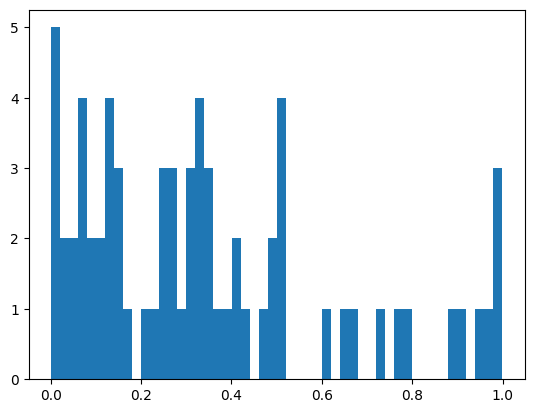

In [10]:
plt.hist(adfuller_vals, bins=50)

In [228]:
def total(wmsfes):
    scores = 0
    alpha = 12
    scores = []
    for m in wmsfes:
        score = (1.8 - 1.6 / (1 + np.exp(-alpha * m)))
        scores.append(score)
    return np.sum(scores) / len(wmsfes), scores


class Task:
    def __init__(self, history, orig, pred, period=12):
        assert period in [4,12]
        self.history = history
        self.orig = orig
        self.pred = pred
        self.period = period


def wmsfe(tasks):
    hm = np.array([len(t.orig) for t in tasks])
    km = np.sum(hm)
    scores = []
    for t in tasks:
        assert t is not None
        assert t.orig.shape == t.pred.shape
        disp = np.var(t.history[t.period:] - t.history[:-t.period])
        disp = np.nan_to_num(disp) + 1e-9
        score = np.sum((t.orig - t.pred) ** 2 / (np.arange(len(t.pred)) + 1)) / disp
        scores.append(score)
    return np.sum(scores) / km, scores / hm

class TaskSet:
    def __init__(self):
        self.groups = []
        
    def buildFromTasks(self, tasks2d):
        for g in tasks2d:
            self.addGroup()
            for t in g:
                self.addTask(t)
        return self

    def addTask(self, task):
        self.groups[-1].append(task)

    def addGroup(self):
        self.groups.append([])

    def calcScore(self):
        losses = []
        for g in self.groups:
            loss, _ = wmsfe(g)
            losses.append(loss)
        return total(losses)
    

def leaderboard(tasks2d):
    return TaskSet().buildFromTasks(tasks2d).calcScore()

In [781]:
fred_month = pd.read_csv("fred_md.csv", skiprows=range(1,2), index_col=0)
# downloaded from https://fred.stlouisfed.org
# at https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv 

dates = []

for m in range(1, 13):
    for y in range(2000, 2015):
        dates.append('{}/1/{}'.format(m, y))
        
fred = fred_month[fred_month.index.isin(dates)]
fred = np.log(1 + np.abs(np.nan_to_num(fred)))
print(fred.shape, np.sum(fred))
fred_month.head(10)

(180, 127) 131954.85572995187


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN
6/1/1959,2505.788,2357.4,17.831,301348.7981,18849.75209,23.6319,24.5755,23.3052,32.3184,19.8141,...,17.817,11.463,2.17,2.50,2.09,NaN,6956.0,12926.0,78.6972,NaN
7/1/1959,2504.312,2355.6,17.770,305020.3394,18843.52934,23.0660,24.6042,23.4983,32.7431,20.2064,...,17.835,11.504,2.17,2.51,2.09,NaN,7132.0,13199.0,78.9984,NaN
8/1/1959,2490.236,2342.1,17.877,289435.4569,18963.83587,22.2846,24.4319,23.4431,32.7817,19.6424,...,17.869,11.538,2.17,2.53,2.07,NaN,7309.0,13471.0,77.3045,NaN
9/1/1959,2492.033,2342.1,18.057,293697.8125,18715.96293,22.2577,24.3171,23.3604,32.6659,19.0539,...,17.916,11.572,2.17,2.54,2.08,NaN,7393.0,13657.0,76.8926,NaN


In [229]:
window = None

In [230]:
class Normalizer:
    def __init__(self, period):
        self.period = period
        self.try_fallback = False
    
    def transform(self, X):
        X = remove_nan_prefix(X)
        l = X.shape[0]
        if l < 2 * self.period:
            assert False
            ft = 0 if l == 0 else X[0]
            X = np.array([float(ft)] * (3 * self.period - l) + list(X))
            self.try_fallback = True
        r = seasonal_decompose(X, model="additive", period=self.period)
        trend = X - r.seasonal
        
        mean = np.mean(trend)
        std = np.std(trend)
        trend_norm = (trend - mean) / (std + 1e-9)
        
        self.seasonal = r.seasonal
        self.mean = mean
        self.std = std
#         self.trend_model = trend_model
        return trend_norm
    def inverse(self, X):
        X *= self.std
        X += self.mean
        seasons = np.tile(self.seasonal, len(X) // len(self.seasonal) + 1)[:len(X)]
        X += seasons
        return X

In [231]:
class BaseModel:
    def fit(self, X, y):
        pass
    def predict(self, X):
        pass
    
class ZeroModel(BaseModel):
    def predict(self,_):
        return [0]

class LastConstModel(BaseModel):
    def predict(self, X):
        return [X[0][-1]]
    
class FirstConstModel(BaseModel):
    def __init__(self):
        self.const = None

    def predict(self, X):
        if self.const is None:
            self.const = X[0][-1]
        return [self.const]
    
class Weighted(BaseModel):
    def __init__(self, weights, base_model):
        self.weights = weights
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X * self.weights, y)
    def predict(self, X):
        return self.base_model.predict(X * self.weights)
    
class Scaled(BaseModel):
    def __init__(self, weight, base_model):
        self.weight = weight
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X, y)
    def predict(self, X):
        return self.base_model.predict(X) * self.weight
    
class PredictWithDelta(BaseModel):
    def __init__(self, base_model):
        self.base_model = base_model
    def predict(self, X):
        y = self.base_model.predict(X)
        return X[:, -1] + y

In [782]:
def add_cumulative_noise(X, weight=1e-2):
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    Z = np.random.normal(size=X.shape)
    W = np.tile(np.arange(X.shape[0], 0, -1).reshape(-1, 1), X.shape[1]) / X.shape[0] * weight
    Z = np.cumsum(Z, axis=0) * W
    return X * (1 + Z)

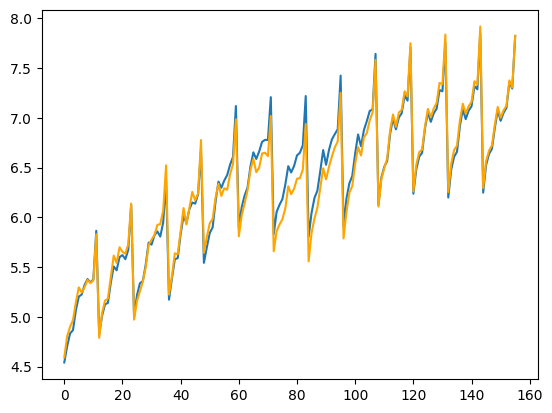

In [785]:
withNoise = add_cumulative_noise(train_data.values)

T = 15
plt.plot(train_data.values[:, T])
plt.plot(withNoise[:, T], "orange")

In [786]:
import tqdm

class SearchSequenceIndex:
    def __init__(self, window, period, offset):
        self.window = window
        self.period = period
        self.offset = offset
        
    def get_train_part_and_full(self, X, remove_prefix=0):
        train_gap = self.offset + self.period + self.window
        X = X[remove_prefix:]
        T = X[:-train_gap]
        return T, X
    
    def build(self, X):
        N = len(X)
        self.X_normed = []

        for i in np.arange(N):
            x = X[i]
            x = Normalizer(self.period).transform(x)
            for j in range(len(x) - self.window - 1):
                sample = x[j:j + self.window + 1]
                self.X_normed.append(sample)
        self.X_normed = np.array(self.X_normed)
    
    def fit(self, base_model):
        self.base_model = base_model
        X_train = np.array([x[:-1] for x in self.X_normed])
        y_train = np.array([x[-1] - x[-2] for x in self.X_normed])
        self.base_model.fit(X_train, y_train)
        self.base_model = PredictWithDelta(self.base_model)
        
    def predict_for_seq(self, seq, steps):
        assert len(seq.shape) == 1, seq.shape[0] >= 2 * self.window
        normalizer = Normalizer(self.period)
        seq = normalizer.transform(seq)
        for i in np.arange(steps):
            subSeq = seq[-self.window:]
            origSubSeq = subSeq
            x = subSeq.reshape(1,-1)
            if normalizer.try_fallback:
                y = PredictWithDelta(ZeroModel()).predict(x)[0]
            else:
                y = self.base_model.predict(x)[0]
            subSeq = list(subSeq) + [y]
            assert np.mean((subSeq[:-1] - origSubSeq) ** 2) < 1e-6, (subSeq, origSubSeq)
            seq = np.append(seq, subSeq[-1])
        seq = normalizer.inverse(seq)
        return seq

    def measure_on_all_train_data(self, X, offset):
        mse = 0
        N = len(X)
        tasks = []
        for t in np.arange(N):
            history = remove_nan_prefix(X[t])
            window_data = history[:-offset]
            r = self.predict_for_seq(window_data, offset)
            task = Task(window_data, history[-offset:], r[-offset:])
            tasks.append(task)
        return tasks
    
def index_series(X, window, period, model, step=1, noise_iters=0, noise_weight=1e-2, global_offset=15, sample=1, outer_data=None):
    np.random.seed(0)
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    xlen = X.shape[0]
    scores = []
    losses = []
    use_noise = True if noise_iters > 0 else False
    noise_iters = max(1, noise_iters)
    for t in range(noise_iters):
        for offset in tqdm.tqdm(np.arange(0, xlen - 2 * (period + window + global_offset) - 1, step), position=0):
            index = SearchSequenceIndex(window, period, global_offset)
            T, F = index.get_train_part_and_full(X, offset)
            if sample < 1:
                T = T[:, np.random.choice(np.arange(T.shape[1]),size=int(T.shape[1] * sample), replace=False)]
            if use_noise:
                T = add_cumulative_noise(T, noise_weight)
            if outer_data is not None:
                history = [t for t in T.T] + [t for t in outer_data]
            else:
                history = T.T
            index.build(history)
            index.fit(model())
            res = index.measure_on_all_train_data(np.transpose(F), global_offset)
            mean_loss, _losses = wmsfe(res)
            score, scores = total(_losses)
            scores.extend(scores)
            losses.extend(_losses)
    return np.array(scores), np.array(losses)

In [788]:
zero_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:ZeroModel(),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75,
    outer_data=list(fred.T) + quartal_int
)

knn_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:Scaled(0.5, KNeighborsRegressor(n_neighbors=50)),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75,
    outer_data=list(fred.T) + quartal_int
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


In [797]:
reg = MLPRegressor(hidden_layer_sizes = (windowm, 32, 16, 32, windowm), 
                   activation = 'tanh', 
                   solver = 'adam',
                   batch_size=32,
#                    learning_rate_init = 0.0001, 
#                    max_iter = 20, 
#                    tol = 0.0000001, 
                   verbose = True)

In [716]:
def encoder(reg, data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    encoder1 = 1 / (1 + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    encoder1 = 1 / (1 + np.exp(-encoder1))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

class AutoencKnnWrapper(BaseModel):
    def __init__(self, enc, knn, err_bound=0):
        self.enc = enc
        self.knn = knn
    def fit(self, X, y):
        ids = np.arange(len(X))
        self.enc.fit(X, X)
        X_enc = encoder(self.enc, X)
        self.knn.fit(X_enc, y)
    def predict(self, X):
        X_enc = encoder(self.enc, X)
        return self.knn.predict(X_enc)

In [802]:
enc_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75,
    outer_data=list(fred.T) + quartal_int
)

  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.04755150
Iteration 2, loss = 0.01622750
Iteration 3, loss = 0.01267053
Iteration 4, loss = 0.01115932
Iteration 5, loss = 0.01020180
Iteration 6, loss = 0.00940208
Iteration 7, loss = 0.00886598
Iteration 8, loss = 0.00847459
Iteration 9, loss = 0.00819461
Iteration 10, loss = 0.00799402
Iteration 11, loss = 0.00781141
Iteration 12, loss = 0.00770306
Iteration 13, loss = 0.00748013
Iteration 14, loss = 0.00732397
Iteration 15, loss = 0.00725618
Iteration 16, loss = 0.00709724
Iteration 17, loss = 0.00705910
Iteration 18, loss = 0.00697201
Iteration 19, loss = 0.00693884
Iteration 20, loss = 0.00689335
Iteration 21, loss = 0.00686239
Iteration 22, loss = 0.00681958
Iteration 23, loss = 0.00683175
Iteration 24, loss = 0.00682262
Iteration 25, loss = 0.00672544
Iteration 26, loss = 0.00675269
Iteration 27, loss = 0.00675008
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:17<01:08, 17.11s/it]

Iteration 1, loss = 0.05030461
Iteration 2, loss = 0.01709905
Iteration 3, loss = 0.01341835
Iteration 4, loss = 0.01161314
Iteration 5, loss = 0.01038180
Iteration 6, loss = 0.00961955
Iteration 7, loss = 0.00907380
Iteration 8, loss = 0.00872591
Iteration 9, loss = 0.00850924
Iteration 10, loss = 0.00826909
Iteration 11, loss = 0.00802924
Iteration 12, loss = 0.00792147
Iteration 13, loss = 0.00770858
Iteration 14, loss = 0.00758986
Iteration 15, loss = 0.00738389
Iteration 16, loss = 0.00724161
Iteration 17, loss = 0.00716782
Iteration 18, loss = 0.00707743
Iteration 19, loss = 0.00699691
Iteration 20, loss = 0.00697151
Iteration 21, loss = 0.00689135
Iteration 22, loss = 0.00687580
Iteration 23, loss = 0.00685052
Iteration 24, loss = 0.00685142
Iteration 25, loss = 0.00678997
Iteration 26, loss = 0.00681067
Iteration 27, loss = 0.00676605
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:34<00:51, 17.05s/it]

Iteration 1, loss = 0.04707904
Iteration 2, loss = 0.01554000
Iteration 3, loss = 0.01205535
Iteration 4, loss = 0.01054431
Iteration 5, loss = 0.00947628
Iteration 6, loss = 0.00865804
Iteration 7, loss = 0.00807994
Iteration 8, loss = 0.00769139
Iteration 9, loss = 0.00734644
Iteration 10, loss = 0.00710281
Iteration 11, loss = 0.00688420
Iteration 12, loss = 0.00674693
Iteration 13, loss = 0.00674849
Iteration 14, loss = 0.00653492
Iteration 15, loss = 0.00651780
Iteration 16, loss = 0.00644467
Iteration 17, loss = 0.00640949
Iteration 18, loss = 0.00633638
Iteration 19, loss = 0.00629313
Iteration 20, loss = 0.00627475
Iteration 21, loss = 0.00622781
Iteration 22, loss = 0.00620985
Iteration 23, loss = 0.00620426
Iteration 24, loss = 0.00614457
Iteration 25, loss = 0.00614300
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:49<00:32, 16.43s/it]

Iteration 1, loss = 0.05060684
Iteration 2, loss = 0.01626703
Iteration 3, loss = 0.01255785
Iteration 4, loss = 0.01081949
Iteration 5, loss = 0.00973922
Iteration 6, loss = 0.00896573
Iteration 7, loss = 0.00849262
Iteration 8, loss = 0.00811493
Iteration 9, loss = 0.00782971
Iteration 10, loss = 0.00761407
Iteration 11, loss = 0.00744091
Iteration 12, loss = 0.00730051
Iteration 13, loss = 0.00719144
Iteration 14, loss = 0.00702870
Iteration 15, loss = 0.00681683
Iteration 16, loss = 0.00671655
Iteration 17, loss = 0.00662111
Iteration 18, loss = 0.00650460
Iteration 19, loss = 0.00646461
Iteration 20, loss = 0.00641520
Iteration 21, loss = 0.00635707
Iteration 22, loss = 0.00626101
Iteration 23, loss = 0.00626091
Iteration 24, loss = 0.00623313
Iteration 25, loss = 0.00618975
Iteration 26, loss = 0.00616766
Iteration 27, loss = 0.00612762
Iteration 28, loss = 0.00609289
Iteration 29, loss = 0.00611757
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [01:07<00:16, 16.97s/it]

Iteration 1, loss = 0.04910092
Iteration 2, loss = 0.01547730
Iteration 3, loss = 0.01192200
Iteration 4, loss = 0.01054826
Iteration 5, loss = 0.00957216
Iteration 6, loss = 0.00884207
Iteration 7, loss = 0.00820350
Iteration 8, loss = 0.00772843
Iteration 9, loss = 0.00742500
Iteration 10, loss = 0.00713511
Iteration 11, loss = 0.00698223
Iteration 12, loss = 0.00679090
Iteration 13, loss = 0.00662284
Iteration 14, loss = 0.00653788
Iteration 15, loss = 0.00642680
Iteration 16, loss = 0.00636190
Iteration 17, loss = 0.00631399
Iteration 18, loss = 0.00624477
Iteration 19, loss = 0.00615870
Iteration 20, loss = 0.00620481
Iteration 21, loss = 0.00613085
Iteration 22, loss = 0.00608085
Iteration 23, loss = 0.00610071
Iteration 24, loss = 0.00606444
Iteration 25, loss = 0.00602913
Iteration 26, loss = 0.00600824
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.04776467
Iteration 2, loss = 0.01586097
Iteration 3, loss = 0.01232647
Iteration 4, loss = 0.01088874
Iteration 5, loss = 0.00997451
Iteration 6, loss = 0.00937067
Iteration 7, loss = 0.00889378
Iteration 8, loss = 0.00858387
Iteration 9, loss = 0.00825118
Iteration 10, loss = 0.00803455
Iteration 11, loss = 0.00785550
Iteration 12, loss = 0.00766506
Iteration 13, loss = 0.00750737
Iteration 14, loss = 0.00739573
Iteration 15, loss = 0.00728474
Iteration 16, loss = 0.00720577
Iteration 17, loss = 0.00715479
Iteration 18, loss = 0.00707605
Iteration 19, loss = 0.00698532
Iteration 20, loss = 0.00697637
Iteration 21, loss = 0.00684381
Iteration 22, loss = 0.00672376
Iteration 23, loss = 0.00668087
Iteration 24, loss = 0.00660788
Iteration 25, loss = 0.00658981
Iteration 26, loss = 0.00656107
Iteration 27, loss = 0.00649397
Iteration 28, loss = 0.00650881
Iteration 29, loss = 0.00644798
Iteration 30, loss = 0.00650503
Iteration 31, loss = 0.00641645
Iteration 32, los

 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:20<01:22, 20.58s/it]

Iteration 1, loss = 0.04800200
Iteration 2, loss = 0.01575974
Iteration 3, loss = 0.01215519
Iteration 4, loss = 0.01038399
Iteration 5, loss = 0.00937084
Iteration 6, loss = 0.00875154
Iteration 7, loss = 0.00822008
Iteration 8, loss = 0.00775963
Iteration 9, loss = 0.00747638
Iteration 10, loss = 0.00716730
Iteration 11, loss = 0.00692672
Iteration 12, loss = 0.00673618
Iteration 13, loss = 0.00662616
Iteration 14, loss = 0.00652964
Iteration 15, loss = 0.00643696
Iteration 16, loss = 0.00639242
Iteration 17, loss = 0.00638040
Iteration 18, loss = 0.00628363
Iteration 19, loss = 0.00630876
Iteration 20, loss = 0.00623589
Iteration 21, loss = 0.00622843
Iteration 22, loss = 0.00617900
Iteration 23, loss = 0.00623821
Iteration 24, loss = 0.00613583
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:35<00:52, 17.49s/it]

Iteration 1, loss = 0.05526730
Iteration 2, loss = 0.01740902
Iteration 3, loss = 0.01334246
Iteration 4, loss = 0.01150529
Iteration 5, loss = 0.01036952
Iteration 6, loss = 0.00968112
Iteration 7, loss = 0.00917003
Iteration 8, loss = 0.00878627
Iteration 9, loss = 0.00849888
Iteration 10, loss = 0.00811085
Iteration 11, loss = 0.00781596
Iteration 12, loss = 0.00760072
Iteration 13, loss = 0.00740322
Iteration 14, loss = 0.00727126
Iteration 15, loss = 0.00704836
Iteration 16, loss = 0.00694771
Iteration 17, loss = 0.00685563
Iteration 18, loss = 0.00681890
Iteration 19, loss = 0.00676520
Iteration 20, loss = 0.00665717
Iteration 21, loss = 0.00663785
Iteration 22, loss = 0.00658709
Iteration 23, loss = 0.00658243
Iteration 24, loss = 0.00653679
Iteration 25, loss = 0.00648858
Iteration 26, loss = 0.00647878
Iteration 27, loss = 0.00644593
Iteration 28, loss = 0.00644067
Iteration 29, loss = 0.00639502
Iteration 30, loss = 0.00642900
Iteration 31, loss = 0.00637804
Training loss did

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:54<00:36, 18.22s/it]

Iteration 1, loss = 0.04796573
Iteration 2, loss = 0.01503027
Iteration 3, loss = 0.01206749
Iteration 4, loss = 0.01090079
Iteration 5, loss = 0.00999659
Iteration 6, loss = 0.00924969
Iteration 7, loss = 0.00865394
Iteration 8, loss = 0.00827194
Iteration 9, loss = 0.00803134
Iteration 10, loss = 0.00784540
Iteration 11, loss = 0.00766285
Iteration 12, loss = 0.00748572
Iteration 13, loss = 0.00731800
Iteration 14, loss = 0.00721049
Iteration 15, loss = 0.00708733
Iteration 16, loss = 0.00704665
Iteration 17, loss = 0.00694435
Iteration 18, loss = 0.00693102
Iteration 19, loss = 0.00689168
Iteration 20, loss = 0.00679922
Iteration 21, loss = 0.00664584
Iteration 22, loss = 0.00650569
Iteration 23, loss = 0.00646925
Iteration 24, loss = 0.00635698
Iteration 25, loss = 0.00632851
Iteration 26, loss = 0.00631666
Iteration 27, loss = 0.00627039
Iteration 28, loss = 0.00624048
Iteration 29, loss = 0.00623597
Iteration 30, loss = 0.00622052
Iteration 31, loss = 0.00620832
Iteration 32, los

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [01:15<00:19, 19.31s/it]

Iteration 1, loss = 0.04821531
Iteration 2, loss = 0.01590838
Iteration 3, loss = 0.01268061
Iteration 4, loss = 0.01094614
Iteration 5, loss = 0.00983951
Iteration 6, loss = 0.00907595
Iteration 7, loss = 0.00848222
Iteration 8, loss = 0.00807698
Iteration 9, loss = 0.00777402
Iteration 10, loss = 0.00745184
Iteration 11, loss = 0.00719621
Iteration 12, loss = 0.00707735
Iteration 13, loss = 0.00692017
Iteration 14, loss = 0.00680749
Iteration 15, loss = 0.00665047
Iteration 16, loss = 0.00656793
Iteration 17, loss = 0.00651453
Iteration 18, loss = 0.00643222
Iteration 19, loss = 0.00638009
Iteration 20, loss = 0.00633952
Iteration 21, loss = 0.00629671
Iteration 22, loss = 0.00629348
Iteration 23, loss = 0.00621999
Iteration 24, loss = 0.00623734
Iteration 25, loss = 0.00619653
Iteration 26, loss = 0.00614074
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.05011175
Iteration 2, loss = 0.01825014
Iteration 3, loss = 0.01427730
Iteration 4, loss = 0.01245869
Iteration 5, loss = 0.01113963
Iteration 6, loss = 0.01011771
Iteration 7, loss = 0.00958773
Iteration 8, loss = 0.00915783
Iteration 9, loss = 0.00883378
Iteration 10, loss = 0.00857241
Iteration 11, loss = 0.00839948
Iteration 12, loss = 0.00822644
Iteration 13, loss = 0.00806956
Iteration 14, loss = 0.00793460
Iteration 15, loss = 0.00781856
Iteration 16, loss = 0.00773254
Iteration 17, loss = 0.00763545
Iteration 18, loss = 0.00746773
Iteration 19, loss = 0.00734573
Iteration 20, loss = 0.00723381
Iteration 21, loss = 0.00714601
Iteration 22, loss = 0.00710210
Iteration 23, loss = 0.00702717
Iteration 24, loss = 0.00702390
Iteration 25, loss = 0.00696505
Iteration 26, loss = 0.00693988
Iteration 27, loss = 0.00693047
Iteration 28, loss = 0.00687712
Iteration 29, loss = 0.00686535
Iteration 30, loss = 0.00689372
Iteration 31, loss = 0.00680575
Training loss did

 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:19<01:18, 19.61s/it]

Iteration 1, loss = 0.04858957
Iteration 2, loss = 0.01558359
Iteration 3, loss = 0.01199757
Iteration 4, loss = 0.01046602
Iteration 5, loss = 0.00959442
Iteration 6, loss = 0.00893912
Iteration 7, loss = 0.00840671
Iteration 8, loss = 0.00791229
Iteration 9, loss = 0.00758324
Iteration 10, loss = 0.00723863
Iteration 11, loss = 0.00706136
Iteration 12, loss = 0.00689132
Iteration 13, loss = 0.00677475
Iteration 14, loss = 0.00668654
Iteration 15, loss = 0.00652963
Iteration 16, loss = 0.00649553
Iteration 17, loss = 0.00638556
Iteration 18, loss = 0.00635160
Iteration 19, loss = 0.00629663
Iteration 20, loss = 0.00623129
Iteration 21, loss = 0.00619891
Iteration 22, loss = 0.00618571
Iteration 23, loss = 0.00612770
Iteration 24, loss = 0.00606670
Iteration 25, loss = 0.00605976
Iteration 26, loss = 0.00604733
Iteration 27, loss = 0.00599113
Iteration 28, loss = 0.00599176
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:37<00:55, 18.41s/it]

Iteration 1, loss = 0.04545488
Iteration 2, loss = 0.01677375
Iteration 3, loss = 0.01266374
Iteration 4, loss = 0.01088450
Iteration 5, loss = 0.00982972
Iteration 6, loss = 0.00913877
Iteration 7, loss = 0.00866659
Iteration 8, loss = 0.00829535
Iteration 9, loss = 0.00796349
Iteration 10, loss = 0.00763563
Iteration 11, loss = 0.00739664
Iteration 12, loss = 0.00724899
Iteration 13, loss = 0.00724642
Iteration 14, loss = 0.00704021
Iteration 15, loss = 0.00694398
Iteration 16, loss = 0.00696018
Iteration 17, loss = 0.00683310
Iteration 18, loss = 0.00688990
Iteration 19, loss = 0.00685588
Iteration 20, loss = 0.00672806
Iteration 21, loss = 0.00663144
Iteration 22, loss = 0.00659024
Iteration 23, loss = 0.00648011
Iteration 24, loss = 0.00645551
Iteration 25, loss = 0.00644205
Iteration 26, loss = 0.00638412
Iteration 27, loss = 0.00632907
Iteration 28, loss = 0.00633776
Iteration 29, loss = 0.00630325
Iteration 30, loss = 0.00630446
Iteration 31, loss = 0.00630267
Iteration 32, los

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:58<00:39, 19.53s/it]

Iteration 1, loss = 0.04949573
Iteration 2, loss = 0.01646146
Iteration 3, loss = 0.01307524
Iteration 4, loss = 0.01122860
Iteration 5, loss = 0.01005766
Iteration 6, loss = 0.00932882
Iteration 7, loss = 0.00886694
Iteration 8, loss = 0.00858818
Iteration 9, loss = 0.00841954
Iteration 10, loss = 0.00820352
Iteration 11, loss = 0.00800568
Iteration 12, loss = 0.00781944
Iteration 13, loss = 0.00761559
Iteration 14, loss = 0.00739729
Iteration 15, loss = 0.00728153
Iteration 16, loss = 0.00716551
Iteration 17, loss = 0.00706603
Iteration 18, loss = 0.00700649
Iteration 19, loss = 0.00689830
Iteration 20, loss = 0.00678082
Iteration 21, loss = 0.00663118
Iteration 22, loss = 0.00658073
Iteration 23, loss = 0.00653610
Iteration 24, loss = 0.00649015
Iteration 25, loss = 0.00645483
Iteration 26, loss = 0.00642533
Iteration 27, loss = 0.00640345
Iteration 28, loss = 0.00640214
Iteration 29, loss = 0.00633312
Iteration 30, loss = 0.00632827
Iteration 31, loss = 0.00634506
Iteration 32, los

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [01:17<00:19, 19.61s/it]

Iteration 1, loss = 0.04976577
Iteration 2, loss = 0.01661465
Iteration 3, loss = 0.01268079
Iteration 4, loss = 0.01062816
Iteration 5, loss = 0.00955865
Iteration 6, loss = 0.00884134
Iteration 7, loss = 0.00843635
Iteration 8, loss = 0.00801948
Iteration 9, loss = 0.00774065
Iteration 10, loss = 0.00748209
Iteration 11, loss = 0.00722186
Iteration 12, loss = 0.00705008
Iteration 13, loss = 0.00687543
Iteration 14, loss = 0.00675256
Iteration 15, loss = 0.00667641
Iteration 16, loss = 0.00654803
Iteration 17, loss = 0.00642273
Iteration 18, loss = 0.00632164
Iteration 19, loss = 0.00622442
Iteration 20, loss = 0.00619442
Iteration 21, loss = 0.00612769
Iteration 22, loss = 0.00609081
Iteration 23, loss = 0.00605039
Iteration 24, loss = 0.00606493
Iteration 25, loss = 0.00603020
Iteration 26, loss = 0.00596308
Iteration 27, loss = 0.00598075
Iteration 28, loss = 0.00594694
Iteration 29, loss = 0.00595305
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.20s/it]


In [790]:
np.mean(knn_measures[0]), np.mean(zero_measures[0]), z_test(knn_measures[0], zero_measures[0])

(0.3478174478827737,
 0.34097475092624124,
 {'p_value': 0.5499695583233601,
  'mu': 0.006842696956532456,
  'sigma': 0.04433154360403846,
  'win_rate': 0.6811594202898551})

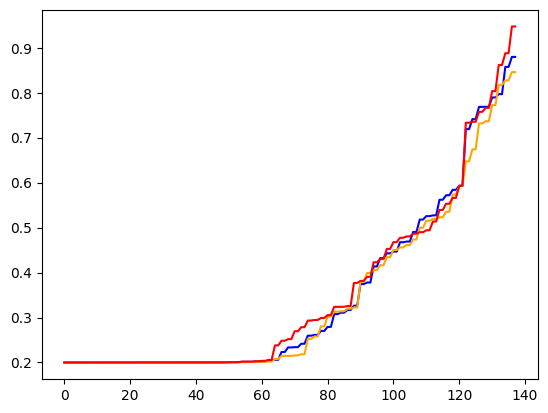

In [791]:
# train + fred + train_quartal_data
plt.plot(np.sort(knn_measures[0]), 'blue')  # knn
plt.plot(np.sort(zero_measures[0]), 'orange')  # baseline
plt.plot(np.sort(enc_measures[0]), 'red')  # aecc + knn

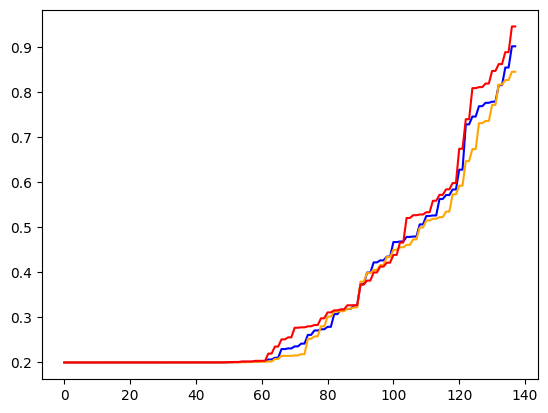

In [761]:
# train + fred
plt.plot(np.sort(knn_measures[0]), 'blue')  # knn
plt.plot(np.sort(zero_measures[0]), 'orange')  # baseline
plt.plot(np.sort(enc_measures[0]), 'red')  # aecc + knn

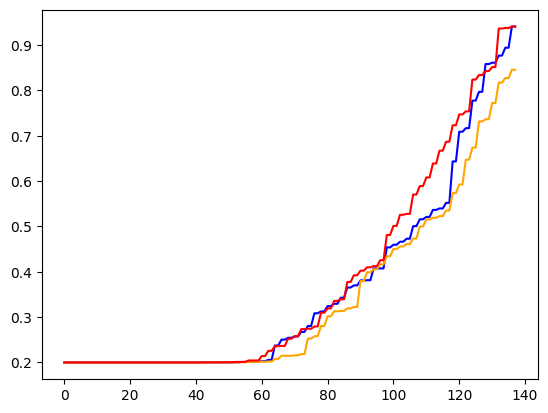

In [720]:
# train wo fred, wo quartal data
plt.plot(np.sort(knn_measures[0]), 'blue')  # knn
plt.plot(np.sort(zero_measures[0]), 'orange')  # baseline
plt.plot(np.sort(enc_measures[0]), 'red')  # aecc + knn

In [792]:
np.mean(knn_measures[1]), np.mean(zero_measures[1]), z_test(knn_measures[1], zero_measures[1])

(1.6602554624001593,
 1.6973818018010343,
 {'p_value': 0.2606740502070265,
  'mu': -0.037126339400874904,
  'sigma': 0.12783585645307252,
  'win_rate': 0.32463768115942027})

In [803]:
np.mean(enc_measures[0]), np.mean(zero_measures[0]), z_test(enc_measures[0], zero_measures[0])

(0.3426100198430045,
 0.34097475092624124,
 {'p_value': 0.24913638433929752,
  'mu': 0.0016352689167631973,
  'sigma': 0.008861343213197325,
  'win_rate': 0.6666666666666666})

In [794]:
np.mean(enc_measures[1]), np.mean(zero_measures[1]), z_test(enc_measures[1], zero_measures[1])

(1.645645910527866,
 1.6973818018010343,
 {'p_value': 0.500733565428954,
  'mu': -0.051735891273168105,
  'sigma': 0.297581371380404,
  'win_rate': 0.3642512077294686})

In [795]:
np.mean(enc_measures[1]), np.mean(knn_measures[1]), z_test(enc_measures[1], knn_measures[1])

(1.645645910527866,
 1.6602554624001593,
 {'p_value': 0.776189586760637,
  'mu': -0.014609551872293198,
  'sigma': 0.19903241247455783,
  'win_rate': 0.3903381642512077})

In [796]:
np.mean(enc_measures[0]), np.mean(knn_measures[0]), z_test(enc_measures[0], knn_measures[0])

(0.3547378705511955,
 0.3478174478827737,
 {'p_value': 0.61436344069341,
  'mu': 0.006920422668421718,
  'sigma': 0.0531952531927507,
  'win_rate': 0.6231884057971014})

In [726]:
train_data.values.shape

(156, 69)

knn:  1.5445594509414997
zero:  1.6253887423863334
log z-test:  {'p_value': 0.006014958469610724, 'mu': 0.20414578353484855, 'sigma': 0.4641086034177921, 'win_rate': 0.6086956521739131}
Iteration 1, loss = 0.14767324
Iteration 2, loss = 0.06320482
Iteration 3, loss = 0.04863330
Iteration 4, loss = 0.04211264
Iteration 5, loss = 0.03837326
Iteration 6, loss = 0.03557247
Iteration 7, loss = 0.03325727
Iteration 8, loss = 0.03150643
Iteration 9, loss = 0.03001305
Iteration 10, loss = 0.02881770
Iteration 11, loss = 0.02769365
Iteration 12, loss = 0.02672974
Iteration 13, loss = 0.02589787
Iteration 14, loss = 0.02522002
Iteration 15, loss = 0.02460073
Iteration 16, loss = 0.02399072
Iteration 17, loss = 0.02339147
Iteration 18, loss = 0.02295095
Iteration 19, loss = 0.02236160
Iteration 20, loss = 0.02187172
Iteration 21, loss = 0.02161235
Iteration 22, loss = 0.02107127
Iteration 23, loss = 0.02075084
Iteration 24, loss = 0.02062721
Iteration 25, loss = 0.02040031
Iteration 26, loss = 0.

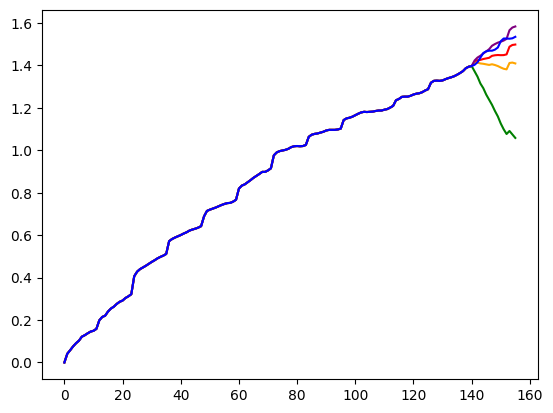

In [799]:
T = 39

offset = 15
index = SearchSequenceIndex(window=12 * 3, period=12, offset=offset)

pref, full = index.get_train_part_and_full(train_data.values)
index.build(pref.T)

orig = train_data.values[:, T]
window_data = orig[:-offset]

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=50)))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(full.T, offset=offset)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0])

index.fit(LinearRegression())
r2 = index.predict_for_seq(window_data, offset)

index.fit(ZeroModel())
r3 = index.predict_for_seq(window_data, offset)
zero_res = index.measure_on_all_train_data(full.T, offset=offset)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0])

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
r4 = index.predict_for_seq(window_data, offset)
res = index.measure_on_all_train_data(full.T, offset=offset)
scores = wmsfe(res)

plt.plot(r1, 'red')
plt.plot(r2, 'green')
plt.plot(r3, 'orange')
plt.plot(r4, 'purple')
plt.plot(train_data.values[:, T], 'blue')
plt.show()

In [731]:
test_data = []
for i in range(14):
    test_data.append(pd.read_excel("../../data/unzipped/Test_example{}.xlsx".format(i+1), index_col=0))

In [732]:
X = []
for i in range(14):
    for f in np.arange(test_data[i].shape[1]):
        seq = test_data[i].values[:, f]
        seq = seq[np.where(seq != "Forecast")]
        if len(seq) >= 12 * 5:
            X.append(seq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [733]:
len([len(x) for x in X if len(x) >= 12 * 5]), len(X)

(58, 58)

In [734]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(train_data.values.T)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(X, offset=15)
knn_scores = wmsfe(knn_res)
print('knn: ', np.mean(knn_scores[0]))#, leaderboard([[x] for x in knn_res]))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
zero_scores = wmsfe(zero_res)

print('zero: ', np.mean(zero_scores[0]))#, leaderboard([[x] for x in zero_res]))

print('z-test: ', z_test(knn_scores[1], zero_scores[1]))

knn:  0.17126421481012874
zero:  0.2180429271995853
z-test:  {'p_value': 0.006926897494078777, 'mu': -0.04677871238945657, 'sigma': 0.1081838346373022, 'win_rate': 0.3275862068965517}


In [653]:
quartal_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0,sheet_name=1)

In [654]:
quartal_data.head()

,"ВВП, млрд",Реальный ВВП,"ВВП A, млрд.руб.","ВВП B, млрд.руб.","ВВП C, млрд.руб.","ВВП D, млрд.руб.","ВВП E, млрд.руб.","ВВП F, млрд.руб.","ВВП G, млрд.руб.","ВВП H, млрд.руб.",...,Реальный ВВП K,Реальный ВВП L,Реальный ВВП M,Реальный ВВП N,Реальный ВВП O,Реальные налоги на продукты,Реальные субсидии на продукты,"Инвестиции, собственные средства, млрд.руб.","Инвестиции, привлеченные средства, млрд.руб.","Инвестиции, бюджетные средства, млрд.руб."
2003m03,8.041233,0.000000,4.273602,2.633625,5.134760,5.926435,4.786542,4.884884,6.374866,2.944192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.872905,4.911183,3.832980
2003m06,8.115856,0.067384,4.520113,2.511972,5.133081,6.073957,4.461686,5.208554,6.393228,3.151690,...,0.032777,0.005775,-0.017488,0.016888,0.049110,0.047356,0.032027,5.249127,5.455748,4.391977
2003m09,8.255223,0.119733,5.690798,2.816459,5.328411,6.158050,4.357089,5.476453,6.477670,3.245579,...,0.042272,0.060595,0.019040,0.037533,0.096204,0.063358,0.211227,5.367843,5.540086,4.513055
2003m12,8.265189,0.171204,4.979387,2.691399,5.296727,6.212625,4.766878,5.468805,6.588304,3.254391,...,0.130738,0.090004,0.043583,0.019568,0.228176,0.100861,0.024644,5.668501,5.927459,4.940213
2004m03,8.250766,0.069902,4.356881,2.822974,5.633453,6.213559,5.063559,5.077852,6.491535,3.362732,...,-0.087127,0.037359,-0.001314,0.011056,0.069604,0.096598,-0.046582,5.017942,5.226284,3.910021


In [656]:
quartal_data.values.shape

(52, 39)

In [704]:
def interpolate_quartal_to_month(seq):
    from scipy import interpolate
    N = len(seq)
    x = np.arange(N)
    y = seq
    f = interpolate.interp1d(x, y, kind='cubic')
    seqint = []
    i = 0
    for i in np.arange(N):
        for j in [0, 1.0 / 3, 2.0 / 3]:
            if i + j > N - 1:
                break
            if j == 0:
                seqint.append(y[i])
            else:
                seqint.append(f(i + j))
    return np.array(seqint)


def extract_quartals_from_months(seq):
    return seq[::3]

In [705]:
interpolate_quartal_to_month([1,2,3,2]), extract_quartals_from_months(interpolate_quartal_to_month([1,2,3,2]))

(array([1.        , 1.20987654, 1.56790123, 2.        , 2.43209877,
        2.79012346, 3.        , 2.98765432, 2.67901235, 2.        ]),
 array([1., 2., 3., 2.]))

In [691]:
quartal_int = []
q_orig = []
for i in np.arange(quartal_data.shape[1]):
    x = quartal_data.values[:, i]
    q_orig.append(x)
    x = interpolate_quartal_to_month(x)
    quartal_int.append(x)

In [787]:
len(q_orig[0]), len(quartal_int[0]), len(quartal_int)

(52, 154, 39)

In [700]:
index.base_model.base_model

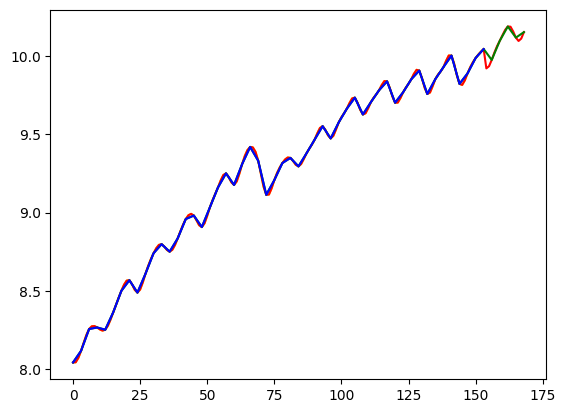

In [708]:
plt.plot(quartal_int[0],'yellow')
q = index.predict_for_seq(quartal_int[0], 15)
q_ = extract_quartals_from_months(q)
plt.plot(q, 'red')
plt.plot(np.arange(0, 3 * len(q_), 3), q_, 'green')
plt.plot(np.arange(0, 3 * len(q_orig[0]), 3), q_orig[0], 'blue')

In [659]:
windowq = 4  * 3

In [770]:
index = SearchSequenceIndex(window=windowm, period=12, offset=15)
history, _ = index.get_train_part_and_full(train_data.values)
# fred_hist, _ = index.get_train_part_and_full(fred)
index.build(list(history.T) + list(fred.T))

index.fit(Scaled(0.1,AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50))))
knn_res = index.measure_on_all_train_data(quartal_int, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(quartal_int, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))
print('z-test scores: ', z_test(knn_scores, zero_scores))
print('z-test loss: ', z_test(knn_losses, zero_losses))

knn:  0.2969552619523851 3.6967167782152828
zero:  0.29551307986774766 3.6954599316972527
z-test scores:  {'p_value': 0.36044023925966784, 'mu': 0.0014421820846374023, 'sigma': 0.008637427411393492, 'win_rate': 0.7435897435897436}
z-test loss:  {'p_value': 0.6886873309974846, 'mu': 0.001256846518030842, 'sigma': 0.01718271221204914, 'win_rate': 0.4358974358974359}


(180, 127)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN
6/1/1959,2505.788,2357.4,17.831,301348.7981,18849.75209,23.6319,24.5755,23.3052,32.3184,19.8141,...,17.817,11.463,2.17,2.50,2.09,NaN,6956.0,12926.0,78.6972,NaN
7/1/1959,2504.312,2355.6,17.770,305020.3394,18843.52934,23.0660,24.6042,23.4983,32.7431,20.2064,...,17.835,11.504,2.17,2.51,2.09,NaN,7132.0,13199.0,78.9984,NaN
8/1/1959,2490.236,2342.1,17.877,289435.4569,18963.83587,22.2846,24.4319,23.4431,32.7817,19.6424,...,17.869,11.538,2.17,2.53,2.07,NaN,7309.0,13471.0,77.3045,NaN
9/1/1959,2492.033,2342.1,18.057,293697.8125,18715.96293,22.2577,24.3171,23.3604,32.6659,19.0539,...,17.916,11.572,2.17,2.54,2.08,NaN,7393.0,13657.0,76.8926,NaN


(180, 127)

#### Обоснование использования датасета fred 

Индекс траекторий построенный по fred значимо улучшает бейзлайн(ничего не знающий об этом индексе)

In [756]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred.T)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(X, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))
print('z-test scores: ', z_test(knn_scores, zero_scores))
print('z-test loss: ', z_test(knn_losses, zero_losses))

knn:  0.4706178153687856 0.173158528518796
zero:  0.43177839979789945 0.21804292719958535
z-test scores:  {'p_value': 0.05752894878730126, 'mu': 0.0388394155708862, 'sigma': 0.1120073550712001, 'win_rate': 0.6724137931034483}
z-test loss:  {'p_value': 0.0881665437470126, 'mu': -0.0448843986807893, 'sigma': 0.1441761997374439, 'win_rate': 0.3275862068965517}


In [710]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(quartal_int, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(quartal_int, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))
print('z-test scores: ', z_test(knn_scores, zero_scores))
print('z-test loss: ', z_test(knn_losses, zero_losses))

Iteration 1, loss = 0.05974639
Iteration 2, loss = 0.01832984
Iteration 3, loss = 0.01378135
Iteration 4, loss = 0.01184043
Iteration 5, loss = 0.01061725
Iteration 6, loss = 0.00985022
Iteration 7, loss = 0.00930340
Iteration 8, loss = 0.00882615
Iteration 9, loss = 0.00849946
Iteration 10, loss = 0.00824188
Iteration 11, loss = 0.00787743
Iteration 12, loss = 0.00774309
Iteration 13, loss = 0.00756577
Iteration 14, loss = 0.00730955
Iteration 15, loss = 0.00718091
Iteration 16, loss = 0.00706829
Iteration 17, loss = 0.00688446
Iteration 18, loss = 0.00678304
Iteration 19, loss = 0.00667189
Iteration 20, loss = 0.00661997
Iteration 21, loss = 0.00653558
Iteration 22, loss = 0.00647830
Iteration 23, loss = 0.00644288
Iteration 24, loss = 0.00635530
Iteration 25, loss = 0.00635062
Iteration 26, loss = 0.00631835
Iteration 27, loss = 0.00627399
Iteration 28, loss = 0.00617916
Iteration 29, loss = 0.00617179
Iteration 30, loss = 0.00606618
Iteration 31, loss = 0.00598648
Iteration 32, los